In [14]:
import math, copy, sys, logging, json, time, random, os, string, pickle, re

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

from modules.TransformerComponents import Transformer
from modules.Vocabulary import Vocab
from modules.MetaLearnNeuralMemory import MNMp
from modules.LoadTrainSave import save_model, load_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(0) 
random.seed(0)
torch.manual_seed(0)

print('torch.version', torch.__version__)
print('torch.cuda.is_available()', torch.cuda.is_available())
print('torch.cuda.device_count()', torch.cuda.device_count())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.version 1.7.0
torch.cuda.is_available() True
torch.cuda.device_count() 2


In [2]:
vocab = Vocab(emb_dim=32)

In [3]:
class Teacher(): 
    
    def __init__(self, vocab):
        self.vocab = vocab
        self.mynameis = vocab.string2tensor("my name is")
        self.hi = vocab.string2tensor("hi")
        self.whatmyname = vocab.string2tensor("what is my name?")
        
    def add_vocab(self,):
        self.vocab.string2embedding("my name is, hi. what is my name?")
        self.vocab.string2embedding("a b c d e f g h i j k l m n o p q r s t u v w x y z")
        
    def randomString(self, stringLength):
        """ Generate a random string of fixed length """
        letters = string.ascii_lowercase
        return ''.join(random.choice(letters) for i in range(stringLength))
    
    def repeat(self, batch_size):
        
        if self.mynameis.shape[0] != batch_size:
            self.mynameis = self.vocab.string2tensor("my name is")
            self.hi = self.vocab.string2tensor("hi")
            self.whatmyname = self.vocab.string2tensor("what is my name?")
            self.mynameis = self.mynameis.repeat(batch_size,1)
            self.hi = self.hi.repeat(batch_size,1)
            self.whatmyname = self.whatmyname.repeat(batch_size,1)
    
    def get_batch(self, batch_size, name_size):
        
        self.repeat(batch_size)
        
        newnames = self.randomString(name_size)
        for n in range(batch_size - 1):
            newnames += " " + self.randomString(name_size)
        self.vocab.string2embedding(newnames)
        self.names = self.vocab.string2tensor(newnames).T

        self.intro = torch.cat((self.mynameis, self.names),dim=1)
        self.introtarget = torch.cat((self.hi, self.names),dim=1)
        return self.intro, self.introtarget, self.whatmyname, self.names

In [4]:
teacher = Teacher(vocab)
teacher.add_vocab()

print(vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


In [5]:
batch_size = 4
name_size = 1
intro, introtarget, whatmyname, names = teacher.get_batch(batch_size, name_size)

In [6]:
intro # my name is <new token>

tensor([[ 4,  5,  6, 24],
        [ 4,  5,  6, 36],
        [ 4,  5,  6, 25],
        [ 4,  5,  6, 13]])

In [7]:
introtarget # hi <new token>

tensor([[ 8, 24],
        [ 8, 36],
        [ 8, 25],
        [ 8, 13]])

In [8]:
whatmyname # what is my name ?

tensor([[10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11]])

In [9]:
names # <new token>

tensor([[24],
        [36],
        [25],
        [13]])

In [51]:
class Bot(nn.Module):
    
    def __init__(self, emb_dim, n_layers, heads, dropout, vocab):
        
        super().__init__()
        
        self.emb_dim = emb_dim
        
        self.vocab = vocab
        self.sos_tok = torch.LongTensor([[self.vocab.word2index["<SOS>"]]]) 
        self.eos_tok = torch.LongTensor([[self.vocab.word2index["<EOS>"]]]) 
        
        self.encodeInput = Transformer(emb_dim, n_layers, heads, dropout)
        self.encodeEncoding = Transformer(emb_dim, n_layers, heads, dropout)
        self.decodeEncoding = Transformer(emb_dim, n_layers, heads, dropout)

        self.mnm = MNMp(emb_dim, heads)
        
        #cntxt_seq_len = 1
        #self.context_vec = nn.Parameter(torch.randn(batch_size,cntxt_seq_len,self.emb_dim), 
        #                                requires_grad=True)
        self.context_vec = None
        
    def memory_utils(self, batch_size):

        if self.context_vec is None:
            cntxt_seq_len = 1
            self.context_vec = torch.randn(batch_size, cntxt_seq_len, self.emb_dim)
            
        if self.context_vec.shape[0] > batch_size:
            self.context_vec = self.context_vec[0,:,:]
            
        if self.context_vec.shape[0] < batch_size:
            self.context_vec = self.context_vec[0,:,:].repeat(batch_size, 1, 1)
    
        self.context_vec = self.context_vec.detach()
        self.mnm.memfunc.detach_mem()
        
    def forward(self, in_toks, in_mask, out_toks, out_mask):
        
        self.memory_utils(batch_size = in_toks.shape[0])
        
        in_vecs = self.vocab.embedding(in_toks)
        out_vec = self.vocab.embedding(out_toks)

        self.context_vec, rcl, rcli = self.mnm(self.context_vec)
        encin_vec = self.encodeInput(in_vecs, in_mask, self.context_vec, None)
        self.context_vec = self.encodeEncoding(self.context_vec, None, encin_vec, None)
        
        dout = self.decodeEncoding(out_vec, out_mask, encin_vec, in_mask)
        
        return dout, rcl, rcli
    
    def teacher_forcing(self, src, trg):
        
        self.train()
        trg_start = torch.cat((self.sos_tok.repeat(trg.shape[0],1), trg),dim=1)
        trg_end = torch.cat((trg, self.eos_tok.repeat(trg.shape[0],1)),dim=1)
        src_mask = (src != self.vocab.word2index["<PAD>"]).unsqueeze(-2)
        trg_mask = (trg_end != self.vocab.word2index["<PAD>"]).unsqueeze(-2)
        
        seq_len = trg_start.size(1) 
        np_mask = np.triu(np.ones((1,seq_len,seq_len)),k=1).astype('uint8')
        np_mask =  torch.from_numpy(np_mask) == 0
        
        if trg.is_cuda:
            np_mask = np_mask.cuda()
            
        trg_mask = trg_mask & np_mask
        
        out_vecs, rcl, rcli = self.forward(src, src_mask, trg_start, trg_mask)
        
        return out_vecs, trg_end, rcl, rcli
    
    def string2string(self, input_string, maxlen = 20):
        
        self.eval()
        in_toks = self.vocab.string2tensor(input_string)
        in_vecs = self.vocab.embedding(in_toks)
        
        self.memory_utils(batch_size=in_toks.shape[0])
        
        self.context_vec, rcl, rcli = self.mnm(self.context_vec)
        encin_vec = self.encodeInput(in_vecs, None, self.context_vec, None)
        self.context_vec = self.encodeEncoding(self.context_vec, None, encin_vec, None)
        
        decode_toks = self.sos_tok
        
        for pos in range(maxlen):
            
            decode_vecs = self.vocab.embedding(decode_toks)
            dout = self.decodeEncoding(decode_vecs, None, encin_vec, None)
            vocabdist = self.vocab.emb2vocab(dout)
            next_toks = torch.argmax(vocabdist, dim=2)
            decode_toks = torch.cat((decode_toks, next_toks[:,-1].unsqueeze(0)), dim=1) 
            
            if next_toks[:,-1] == self.eos_tok.squeeze(0):
                
                toks = decode_toks[0][1:-1].data.cpu().numpy()
                de_str = ' '.join([self.vocab.index2word[int(tok)] for tok in toks])

                return de_str
            
        toks = decode_toks[0].data.cpu().numpy()
        de_str = ' '.join([self.vocab.index2word[tok] for tok in toks])
        return de_str

In [52]:
emb_dim, n_layers, heads, dropout = 32, 2, 2, 0.0

vocab = Vocab(emb_dim)
model = Bot(emb_dim, n_layers, heads, dropout, vocab)

teacher = Teacher(model.vocab)
teacher.add_vocab()

print(model.vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


accuracy 0.8359 celoss 0.4505 rcloss 0.003783 d_rcloss 0.0355 training progress 0.0
Saving Model...
accuracy 0.7422 celoss 0.8049 rcloss 0.00524 d_rcloss 0.0372 training progress 0.0507
accuracy 0.7422 celoss 0.6752 rcloss 0.00757 d_rcloss 0.0372 training progress 0.1013
accuracy 0.7422 celoss 0.8868 rcloss 0.008103 d_rcloss 0.0381 training progress 0.152
accuracy 0.7891 celoss 0.6135 rcloss 0.007461 d_rcloss 0.0366 training progress 0.2027
accuracy 0.8516 celoss 0.3508 rcloss 0.008121 d_rcloss 0.0379 training progress 0.2533
Saving Model...
accuracy 0.8359 celoss 0.4082 rcloss 0.008945 d_rcloss 0.0382 training progress 0.304
accuracy 0.875 celoss 0.3176 rcloss 0.008391 d_rcloss 0.0375 training progress 0.3547
Saving Model...
accuracy 0.9141 celoss 0.2627 rcloss 0.008153 d_rcloss 0.0374 training progress 0.4053
Saving Model...
accuracy 0.8906 celoss 0.2813 rcloss 0.00852 d_rcloss 0.0377 training progress 0.456
accuracy 0.8672 celoss 0.3629 rcloss 0.008102 d_rcloss 0.038 training progre

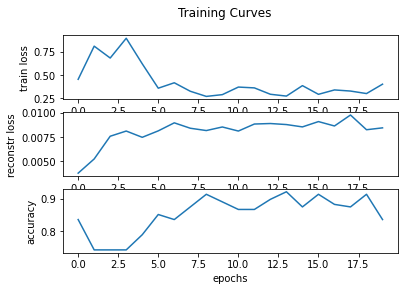

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=0.9,patience=10)

loss_all_list = []
rcloss_all_list = []
accuracy_list = []

total_batches = 1500
best_acc = 0
lamda = 5
batch_size = 64

for batch in range(total_batches):
    
    intro, introtarget, whatmyname, names = teacher.get_batch(batch_size, name_size)
    
    out_vecs, trg_end, rcl, rcli = model.teacher_forcing(intro, introtarget)
    
    vocab_logits = model.vocab.emb2vocab(out_vecs)
    
    predictions = vocab_logits.view(-1, vocab_logits.size(-1))
    target = trg_end.view(-1)

    batch_loss = F.cross_entropy(predictions, target, 
                                 ignore_index = model.vocab.word2index["<PAD>"])

    reconstruction_loss = lamda*rcl
    ################# Next Part of Conversation ########################
    out_vecs, trg_end, rcl, rcli = model.teacher_forcing(whatmyname, names)
    
    vocab_logits = model.vocab.emb2vocab(out_vecs)

    predictions = vocab_logits.view(-1, vocab_logits.size(-1))
    target = trg_end.view(-1)
    
    acc = accuracy_score(target, torch.argmax(predictions, dim=1))

    batch_loss += F.cross_entropy(predictions, target, 
                                 ignore_index = model.vocab.word2index["<PAD>"])
    
    reconstruction_loss += lamda*rcl
    conversation_loss = batch_loss + reconstruction_loss
    
    scheduler.step(conversation_loss)
    optimizer.zero_grad()
    conversation_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if batch % int(total_batches/20 + 1) == 0:
        loss_all_list.append(conversation_loss.float().item())
        rcloss_all_list.append(reconstruction_loss.float().item())
        accuracy_list.append(acc)
        print("accuracy", round(acc,4), 
              "celoss", round(batch_loss.float().item(),4), 
              "rcloss", round(reconstruction_loss.float().item(),6), 
              "d_rcloss", round((rcli - rcl).float().item(),4),
              "training progress", round(batch/total_batches,4))
        if acc > best_acc:
            print('Saving Model...')
            best_acc = acc
            save_model(model,"modelstate/task.pth")
            pickle.dump(model.vocab.word2index,open("modelstate/word2index.p","wb"))
            pickle.dump(model.mnm.memfunc.Ws,open("modelstate/Ws.p","wb"))
            pickle.dump(model.context_vec,open("modelstate/context_vec.p","wb"))

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Training Curves')
ax1.set(xlabel='epochs', ylabel='train loss')
ax2.set(xlabel='epochs', ylabel='reconstr loss')
ax3.set(xlabel='epochs', ylabel='accuracy')
ax1.plot(loss_all_list, label='train loss')
ax2.plot(rcloss_all_list, label='reconstrunction loss')
ax3.plot(accuracy_list, label='accuracy')

In [59]:
load_model(model,"modelstate/task.pth")
model.mnm.memfunc.Ws = pickle.load(open("modelstate/Ws.p","rb"))
model.context_vec = pickle.load(open("modelstate/context_vec.p","rb"))

In [60]:
for tell in [
             'my name is g', 'what is my name?', 
             'my name is b', 'what is my name?',
             'my name is x', 'what is my name?',
             ]:

    print(' > '+ tell)
    
    reply = model.string2string(tell)

    print(' > '+ reply)

    print(' ')

 > my name is g
 > hi g
 
 > what is my name?
 > g
 
 > my name is b
 > hi b
 
 > what is my name?
 > b
 
 > my name is x
 > hi x
 
 > what is my name?
 > x
 
